# PDE-FIND for the Kuramoto Sivashinsky Equation

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND on the Kuramoto Sivashinsky equation.
$$
u_t + u_{xxxx} + uu_x + u_{xx} = 0
$$

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import os

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
cwd = os.getcwd()
print(cwd)


data = sio.loadmat(os.path.join(cwd,'Datasets','kuramoto_sivishinky.mat'))
u = data['uu']
x = data['x'][:,0]
t = data['tt'][0,:]
dt = t[1]-t[0]
dx = x[2]-x[1]

n = len(x)
m = len(t)

/workspaces/VSC_files/ModellingFromMeasurements/homework_sindy


In [3]:
for key in data.keys():
    print(key)

__header__
__version__
__globals__
x
uu
tt


Text(0.5, 0, 't')

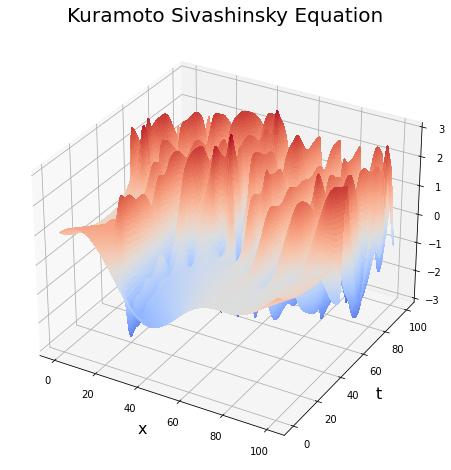

In [11]:
X, T = np.meshgrid(x, t)
fig1 = figure(facecolor="white")
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(X, T, u.T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
title('Kuramoto Sivashinsky Equation', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('t', fontsize = 16)

## Construct $\Theta (U)$ and compute $U_t$

The function build_linear_system does this for us.  We specify <br>
D = highest derivative to appear in $\Theta$  <br>
P = highest degree polynomial of $u$ to appear in $\Theta$ (not including multiplication by a derivative.  <br>
time_diff and space_diff taken via finite differences

Printed out is a list of candidate functions for the PDE.  Each is a column of $\Theta (U)$

In [5]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=5, P=5, time_diff = 'FD', space_diff = 'FD')

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [6]:
w = TrainSTRidge(R,Ut,10**-5,5)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-0.984053 +0.000000i)uu_{x}
    + (-0.993750 +0.000000i)u_{xx}
    + (-0.998328 +0.000000i)u_{xxxx}
   


In [7]:
err = abs(np.array([(1-0.984425)*100/0.5, (1-0.994175)*100, (1-0.998730)*100]))
print(mean(err))
print(std(err))

1.2748333333333324
1.3144149733711288


## Now identify the same dynamics but with added noise.

The only difference from above is that finite differences work poorly for noisy data so here we use polynomial interpolation.  With deg_x or deg_t and width_x or width_t we specify the degree number of points used to fit the polynomials used for differentiating x or t.  Unfortunately, the result can be sensitive to these.

In [8]:
numpy.random.seed(0)
un = u + 0.01*std(u)*np.random.randn(u.shape[0],u.shape[1])

In [9]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=5, P=5, 
                                 time_diff = 'poly', space_diff = 'poly', 
                                 width_x = 20, width_t = 20, deg_x = 6)
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,5)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-0.489801 +0.000000i)uu_{x}
    + (-0.526410 +0.000000i)u_{xx}
    + (-0.537195 +0.000000i)u_{xxxx}
   


In [10]:
err = abs(np.array([(1-0.458521)*100, (1-0.480667)*100, (1-0.492282)*100]))
print(mean(err))
print(std(err))

52.284333333333336
1.4004597110314283
